# 🛒 Hệ thống Đề xuất cho Bán lẻ/Thương mại điện tử

- Xây dựng đặc trưng (Feature engineering): độ phổ biến sản phẩm, hồ sơ người dùng, đặc trưng về phiên và thời gian
- Làm sạch và biến đổi dữ liệu
- Các mô hình: Phổ biến nhất (Most Popular), GRU4Rec
- Tinh chỉnh siêu tham số để tìm cấu hình mô hình tốt nhất
- Demo thân thiện với người dùng (Top 5 đề xuất kèm xác suất)
- Toàn bộ code sẵn sàng để mở rộng hoặc tích hợp

In [1]:
# Cài đặt các thư viện cần thiết nếu chưa có
# !pip install pandas numpy scikit-learn torch matplotlib

## 1. Tải Dữ liệu & Thống kê Ban đầu

Kích thước dữ liệu thô: (2756101, 5)


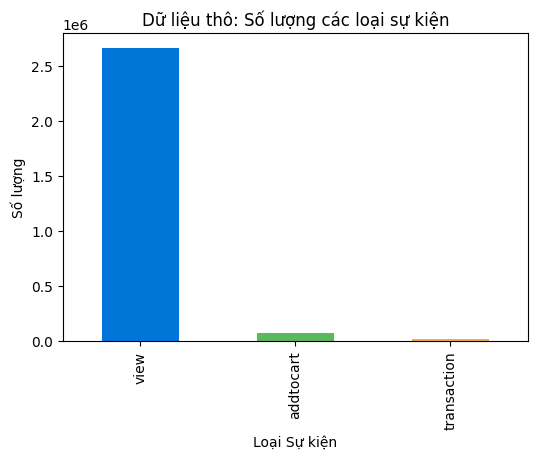

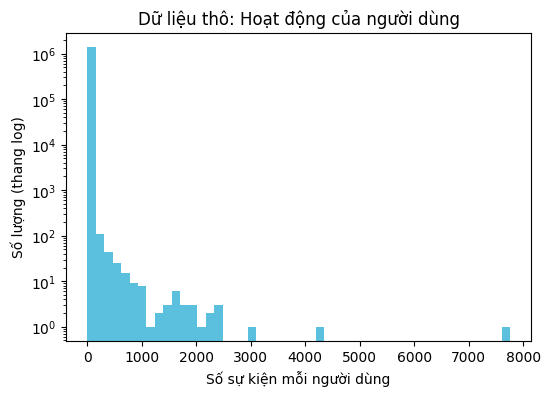

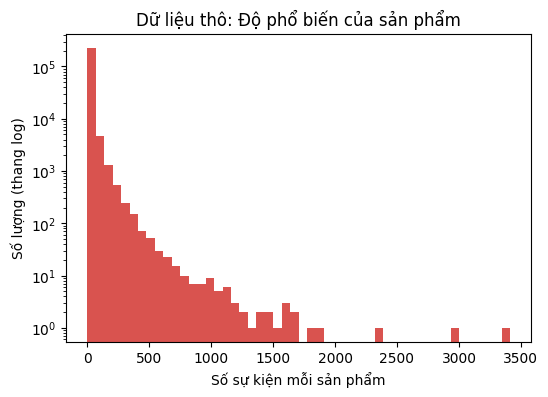

In [2]:
# Nhập các thư viện cần thiết
# pandas: Dùng để làm việc với dữ liệu dạng bảng (giống Excel).
# numpy: Dùng cho các phép toán số học hiệu suất cao.
# scikit-learn: Cung cấp các công cụ xử lý dữ liệu đơn giản.
# matplotlib: Dùng để vẽ biểu đồ và trực quan hóa dữ liệu.
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Tải dữ liệu từ tệp events.csv. Đây là file chứa log hành vi của người dùng.
events = pd.read_csv('events.csv')
raw_events = events.copy() # Tạo một bản sao để so sánh trước và sau khi xử lý

# Hàm vẽ biểu đồ cột cho các loại sự kiện (xem, thêm vào giỏ, mua hàng)
def plot_event_type_bar(df, title):
    plt.figure(figsize=(6,4))
    df['event'].value_counts().plot(kind='bar', color=['#0275d8','#5cb85c','#f0ad4e'])
    plt.title(title)
    plt.xlabel("Loại Sự kiện")
    plt.ylabel("Số lượng")
    plt.show()

# Hàm vẽ biểu đồ histogram (biểu đồ tần suất) để xem phân phối của dữ liệu
def plot_hist_by_group(df, group_col, title, xlabel, color):
    plt.figure(figsize=(6,4))
    # Dữ liệu được nhóm lại và vẽ dưới dạng histogram. Thang log được dùng để các giá trị chênh lệch lớn dễ nhìn hơn.
    df.groupby(group_col).size().plot(kind='hist', bins=50, log=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Số lượng (thang log)")
    plt.show()

# In ra kích thước dữ liệu thô và vẽ các biểu đồ thống kê ban đầu
print(f"Kích thước dữ liệu thô: {raw_events.shape}")
plot_event_type_bar(raw_events, "Dữ liệu thô: Số lượng các loại sự kiện")
plot_hist_by_group(raw_events, 'visitorid', "Dữ liệu thô: Hoạt động của người dùng", "Số sự kiện mỗi người dùng", '#5bc0de')
plot_hist_by_group(raw_events, 'itemid', "Dữ liệu thô: Độ phổ biến của sản phẩm", "Số sự kiện mỗi sản phẩm", '#d9534f')

## 2. Làm sạch Dữ liệu & Xây dựng Đặc trưng (Feature Engineering)

In [3]:
# --- Giải thích: Tại sao cần các bước này? ---
# Mục tiêu của phần này là biến đổi log sự kiện thô thành một tập dữ liệu sạch, có cấu trúc, phù hợp để huấn luyện mô hình đề xuất.
# Giống như một đầu bếp cần chuẩn bị nguyên liệu sạch trước khi nấu, chúng ta cần dữ liệu "sạch" để mô hình AI hoạt động tốt.

# Xóa các log sự kiện trùng lặp để tránh việc một tương tác bị tính nhiều lần.
events = events.drop_duplicates()

# Chuyển đổi timestamp (một con số dài thể hiện thời gian) sang định dạng ngày-giờ mà con người và máy tính dễ đọc hơn.
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# Loại bỏ bots (các chương trình tự động, không phải người thật).
# Ở đây, chúng ta giả định rằng nếu một "người dùng" tạo ra hơn 200 sự kiện trong một giờ, đó có khả năng là bot.
user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='h')]).size().reset_index(name='event_count')
bots = user_hour[user_hour['event_count'] > 200]['visitorid'].unique()
events = events[~events['visitorid'].isin(bots)]

# Lọc bỏ những người dùng và sản phẩm có quá ít tương tác (dưới 5 lần).
# Điều này giúp mô hình tập trung vào các dữ liệu có ý nghĩa hơn, tránh bị nhiễu bởi các tương tác đơn lẻ, ngẫu nhiên.
active_users = events['visitorid'].value_counts()[lambda x: x >= 5].index
active_items = events['itemid'].value_counts()[lambda x: x >= 5].index
events = events[events['visitorid'].isin(active_users) & events['itemid'].isin(active_items)]

# --- Phân chia Session: Nhóm các sự kiện thành phiên của người dùng ---
# Một session (phiên) là một chuỗi hành động của người dùng trong một lần truy cập.
# Chúng ta định nghĩa một session mới bắt đầu nếu người dùng không hoạt động trong 30 phút. Đây là một tiêu chuẩn phổ biến.
events = events.sort_values(['visitorid', 'datetime'])
events['session_id_num'] = (events.groupby('visitorid')['datetime']
    .diff().gt(timedelta(minutes=30)).cumsum().astype(int))
events['session_id'] = events['visitorid'].astype(str) + '_' + events['session_id_num'].astype(str)

# --- Xây dựng Đặc trưng (Feature Engineering): Thêm các tín hiệu dự đoán mạnh hơn ---
# Chúng ta tạo ra các thông tin mới từ dữ liệu gốc để giúp mô hình "hiểu" rõ hơn về sản phẩm và người dùng.

# Đặc trưng về độ phổ biến của sản phẩm: Đếm số lần một sản phẩm được xem, thêm vào giỏ, và mua.
# Đây là một tín hiệu rất quan trọng cho thấy sức hấp dẫn của sản phẩm.
pop_counts = events.groupby(['itemid', 'event']).size().unstack(fill_value=0)
events['item_view_count'] = events['itemid'].map(pop_counts.get('view', pd.Series()))
events['item_addtocart_count'] = events['itemid'].map(pop_counts.get('addtocart', pd.Series()))
events['item_transaction_count'] = events['itemid'].map(pop_counts.get('transaction', pd.Series()))

# Đặc trưng hồ sơ người dùng: Tóm tắt hành vi trong quá khứ của người dùng.
user_total_sessions = events.groupby('visitorid')['session_id'].nunique()
events['user_total_sessions'] = events['visitorid'].map(user_total_sessions)
user_total_purchases = events[events['event'] == 'transaction'].groupby('visitorid').size()
events['user_total_purchases'] = events['visitorid'].map(user_total_purchases).fillna(0)
if 'categoryid' in events.columns:
    def preferred_categories(x):
        return pd.Series(x).value_counts().index[:3].tolist()
    user_pref_cats = events.groupby('visitorid')['categoryid'].apply(preferred_categories)
    events['user_preferred_categories'] = events['visitorid'].map(user_pref_cats)
else:
    events['user_preferred_categories'] = None


# Đặc trưng dựa trên thời gian: Giúp mô hình nhận biết các xu hướng theo ngày trong tuần hoặc giờ trong ngày.
events['day_of_week'] = events['datetime'].dt.dayofweek
events['hour_of_day'] = events['datetime'].dt.hour

# Gán trọng số cho sự kiện: Hành động "mua hàng" (transaction) quan trọng hơn "xem" (view).
# Chúng ta gán một con số (trọng số) để thể hiện mức độ quan trọng này cho mô hình.
event_map = {'view': 1, 'addtocart': 3, 'transaction': 5}
events['event_weight'] = events['event'].map(event_map)

# Mã hóa ID (ID Encoding): Các mô hình AI làm việc tốt hơn với số nguyên liên tục (0, 1, 2,...) thay vì các ID dạng chuỗi dài.
# LabelEncoder giống như việc cấp cho mỗi người dùng/sản phẩm một số báo danh duy nhất.
user_enc = LabelEncoder()
item_enc = LabelEncoder()
session_enc = LabelEncoder()
events['user_idx'] = user_enc.fit_transform(events['visitorid'])
events['item_idx'] = item_enc.fit_transform(events['itemid'])
events['session_idx'] = session_enc.fit_transform(events['session_id'])

# Đặc trưng của session: Cung cấp thông tin về thời lượng và số sự kiện trong một phiên.
session_info = events.groupby('session_id').agg(
    session_start=('datetime', 'min'),
    session_end=('datetime', 'max'),
    events_per_session=('event', 'count')
)
session_info['session_duration'] = (session_info['session_end'] - session_info['session_start']).dt.total_seconds()
events['session_duration'] = events['session_id'].map(session_info['session_duration'])
events['events_per_session'] = events['session_id'].map(session_info['events_per_session'])

## 3. Thống kê sau khi Làm sạch

Kích thước dữ liệu sau khi làm sạch: (895965, 22)


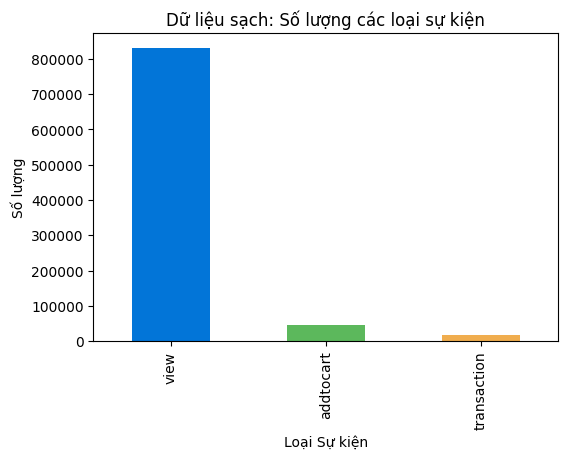

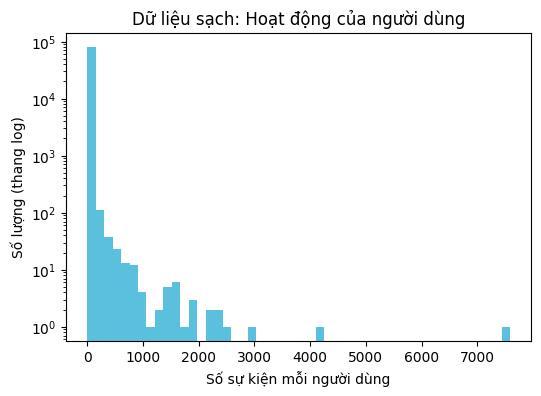

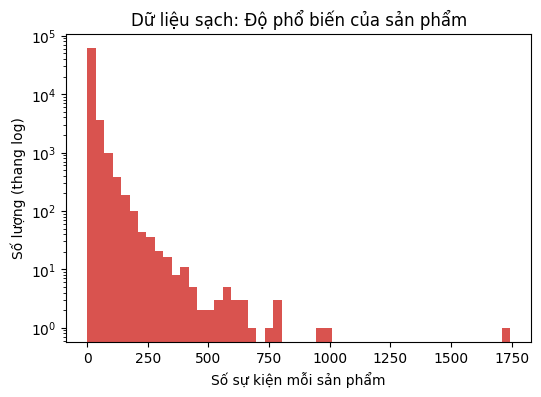

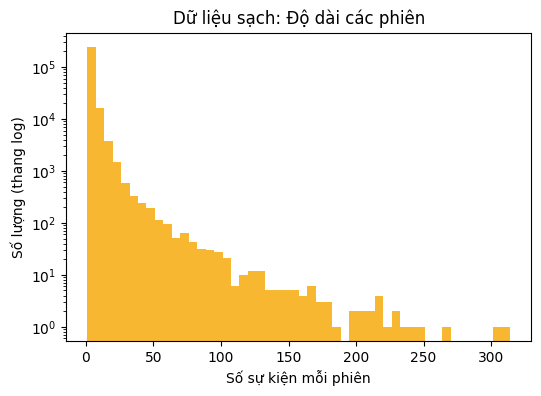

In [4]:
print(f"Kích thước dữ liệu sau khi làm sạch: {events.shape}")
plot_event_type_bar(events, "Dữ liệu sạch: Số lượng các loại sự kiện")
plot_hist_by_group(events, 'visitorid', "Dữ liệu sạch: Hoạt động của người dùng", "Số sự kiện mỗi người dùng", '#5bc0de')
plot_hist_by_group(events, 'itemid', "Dữ liệu sạch: Độ phổ biến của sản phẩm", "Số sự kiện mỗi sản phẩm", '#d9534f')
plot_hist_by_group(events, 'session_id', "Dữ liệu sạch: Độ dài các phiên", "Số sự kiện mỗi phiên", '#f7b731')

## 4. Phân chia Dữ liệu (Theo Thời gian)

In [5]:
# Chúng ta chia dữ liệu thành 3 phần: train, validation, và test.
# - train: Dữ liệu để "dạy" cho mô hình.
# - validation: Dữ liệu để "tinh chỉnh" các cài đặt của mô hình.
# - test: Dữ liệu để "kiểm tra cuối kỳ", đánh giá hiệu suất cuối cùng của mô hình.
# Việc chia theo thời gian (dữ liệu cũ để huấn luyện, dữ liệu mới để kiểm tra) là rất quan trọng để mô phỏng đúng thực tế.
max_date = events['datetime'].max()
train_cutoff = max_date - timedelta(weeks=2)
val_cutoff = max_date - timedelta(weeks=1)

train = events[events['datetime'] < train_cutoff]
valid = events[(events['datetime'] >= train_cutoff) & (events['datetime'] < val_cutoff)]
test = events[events['datetime'] >= val_cutoff]

## 5. Mô hình Phổ biến nhất (Baseline)

In [6]:
# Đây là mô hình đơn giản nhất, không cá nhân hóa.
# Nó chỉ đơn giản đề xuất các sản phẩm được nhiều người tương tác nhất trong quá khứ.
# Chúng ta dùng nó làm "mức hiệu suất tối thiểu" để so sánh với các mô hình phức tạp hơn.
most_popular = train['item_idx'].value_counts().index[:20].tolist()

## 6. Mô hình GRU4Rec (PyTorch, phiên bản Demo)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --- Giải thích các khái niệm AI ---
# Dataset: Giống như một cuốn album ảnh, nó sắp xếp dữ liệu huấn luyện của chúng ta. Mỗi "bức ảnh" là một ví dụ học (một đoạn session và sản phẩm tiếp theo).
# DataLoader: Giống như một băng chuyền, nó đưa các "bức ảnh" (dữ liệu) cho mô hình theo từng lô nhỏ, dễ quản lý.
class SessionDataset(Dataset):
    def __init__(self, seqs, maxlen=10):
        self.samples = []
        # Tạo ra các cặp (đầu vào, đầu ra) từ mỗi session
        # Ví dụ: session [A, B, C] -> tạo ra ( [A], B ) và ( [A, B], C )
        for seq in seqs:
            for i in range(1, len(seq)):
                start = max(0, i - maxlen)
                self.samples.append((seq[start:i], seq[i]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, label = self.samples[idx]
        # Đảm bảo mỗi chuỗi đầu vào có cùng độ dài bằng cách đệm số 0
        x = np.zeros(10, dtype=int)
        x[-len(seq):] = seq[-10:]
        return torch.LongTensor(x), torch.LongTensor([label])

# --- Giải thích kiến trúc mô hình GRU4Rec ---
# nn.Module: Là bản thiết kế cơ bản cho mọi "bộ não" (mô hình) trong PyTorch.
# nn.Embedding: Một "bảng tra cứu" thông minh, học một mô tả sâu sắc cho mỗi sản phẩm. Thay vì chỉ là một con số, mỗi sản phẩm có một "véc-tơ đặc trưng" thể hiện "tính cách" của nó.
# nn.GRU: Là "trí nhớ" của mô hình. Nó đọc chuỗi sản phẩm người dùng đã xem và cố gắng ghi nhớ mẫu hành vi để dự đoán sản phẩm tiếp theo.
# nn.Linear: Là "bộ phận ra quyết định". Sau khi GRU hiểu được session, lớp này sẽ đưa ra dự đoán cuối cùng cho tất cả các sản phẩm.
class GRU4Rec(nn.Module):
    def __init__(self, n_items, emb_dim=50, hid_dim=100):
        super().__init__()
        self.embedding = nn.Embedding(n_items, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, n_items)
    def forward(self, x):
        emb = self.embedding(x)
        _, h = self.gru(emb)
        out = self.fc(h.squeeze(0))
        return out

# Chuẩn bị dữ liệu chuỗi (sequences) cho việc huấn luyện
seq_df = (train.groupby('session_id')['item_idx'].apply(list).reset_index(name='seq'))
seq_df = seq_df[seq_df['seq'].apply(lambda x: len(x) > 1)]
sequences = seq_df['seq'].tolist()

dataset = SessionDataset(sequences)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Chọn thiết bị để huấn luyện (GPU nếu có, nếu không thì dùng CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 7. Tinh chỉnh Siêu tham số (Hyperparameter Tuning - Demo)

In [8]:
# Như đã đề cập trong báo cáo (mục 4.2), chúng ta sử dụng tập validation để tinh chỉnh siêu tham số.
# Quá trình này giúp tìm ra cấu hình mô hình tốt nhất (ví dụ: tốc độ học, độ phức tạp của mô hình) mà không đụng đến tập test cuối cùng.
# LƯU Ý: Một cuộc tìm kiếm siêu tham số đầy đủ có thể tốn nhiều thời gian. Đoạn code này chỉ minh họa quy trình với một không gian tìm kiếm giới hạn.

def evaluate_model(model, val_sequences, k=20):
    """Tính toán chỉ số recall@k trên tập validation."""
    model.eval()
    recalls = []
    with torch.no_grad():
        for seq in val_sequences:
            if len(seq) < 2: continue
            input_seq = torch.LongTensor([seq[:-1][-10:]]).to(device)
            target = seq[-1]
            logits = model(input_seq)
            topk = logits.cpu().numpy().argsort()[0][-k:][::-1]
            if target in topk:
                recalls.append(1)
            else:
                recalls.append(0)
    return np.mean(recalls)

# Chuẩn bị chuỗi dữ liệu validation
val_seq_df = (valid.groupby('session_id')['item_idx'].apply(list).reset_index(name='seq'))
val_sequences = val_seq_df['seq'].tolist()

# Không gian tìm kiếm siêu tham số (ví dụ)
learning_rates = [0.001, 0.005]
embedding_dims = [50, 100]
hidden_dims = [100, 150]
best_recall = -1
best_params = {}

print("--- Bắt đầu Tinh chỉnh Siêu tham số ---")
for lr in learning_rates:
    for emb_dim in embedding_dims:
        for hid_dim in hidden_dims:
            print(f"Tinh chỉnh với: lr={lr}, emb_dim={emb_dim}, hid_dim={hid_dim}")
            
            # Khởi tạo và huấn luyện mô hình với các tham số hiện tại
            current_model = GRU4Rec(n_items=events['item_idx'].nunique(), emb_dim=emb_dim, hid_dim=hid_dim).to(device)
            optimizer = torch.optim.Adam(current_model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()

            # Vòng lặp huấn luyện rút gọn để tinh chỉnh
            for epoch in range(2):
                current_model.train()
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device).squeeze()
                    optimizer.zero_grad()
                    logits = current_model(xb)
                    loss = loss_fn(logits, yb)
                    loss.backward()
                    optimizer.step()
            
            # Đánh giá trên tập validation
            recall = evaluate_model(current_model, val_sequences)
            print(f"Validation Recall@20: {recall:.4f}")
            
            if recall > best_recall:
                best_recall = recall
                best_params = {'lr': lr, 'emb_dim': emb_dim, 'hid_dim': hid_dim, 'recall': recall}

print(f"--- Hoàn tất Tinh chỉnh ---")
print(f"Các tham số tốt nhất được tìm thấy: {best_params}")

--- Bắt đầu Tinh chỉnh Siêu tham số ---
Tinh chỉnh với: lr=0.001, emb_dim=50, hid_dim=100
Validation Recall@20: 0.2785
Tinh chỉnh với: lr=0.001, emb_dim=50, hid_dim=150
Validation Recall@20: 0.3049
Tinh chỉnh với: lr=0.001, emb_dim=100, hid_dim=100
Validation Recall@20: 0.3041
Tinh chỉnh với: lr=0.001, emb_dim=100, hid_dim=150
Validation Recall@20: 0.3288
Tinh chỉnh với: lr=0.005, emb_dim=50, hid_dim=100
Validation Recall@20: 0.3358
Tinh chỉnh với: lr=0.005, emb_dim=50, hid_dim=150
Validation Recall@20: 0.3285
Tinh chỉnh với: lr=0.005, emb_dim=100, hid_dim=100
Validation Recall@20: 0.3394
Tinh chỉnh với: lr=0.005, emb_dim=100, hid_dim=150
Validation Recall@20: 0.3383
--- Hoàn tất Tinh chỉnh ---
Các tham số tốt nhất được tìm thấy: {'lr': 0.005, 'emb_dim': 100, 'hid_dim': 100, 'recall': 0.3393513874958208}


## 7a. Trực quan hóa Ảnh hưởng của Tinh chỉnh Siêu tham số

--- Đánh giá mô hình với tham số mặc định để so sánh ---
Validation Recall@20 của tham số mặc định: 0.2765


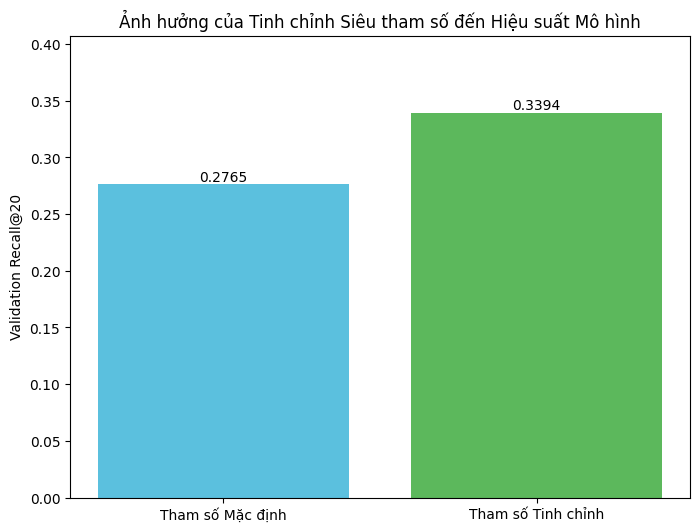

In [9]:
# Phần này minh họa tác động của quá trình tinh chỉnh bằng cách so sánh recall trên tập validation
# của mô hình được huấn luyện với tham số mặc định và mô hình với tham số tốt nhất đã tìm được.

# --- Bước 1: Đánh giá mô hình với tham số mặc định ---
print("--- Đánh giá mô hình với tham số mặc định để so sánh ---")
default_params = {'lr': 0.001, 'emb_dim': 50, 'hid_dim': 100}
default_model = GRU4Rec(
    n_items=events['item_idx'].nunique(),
    emb_dim=default_params['emb_dim'],
    hid_dim=default_params['hid_dim']
).to(device)
optimizer = torch.optim.Adam(default_model.parameters(), lr=default_params['lr'])
loss_fn = nn.CrossEntropyLoss()

# Huấn luyện với tham số mặc định trong 2 epoch (để tương ứng với vòng lặp tinh chỉnh)
for epoch in range(2):
    default_model.train()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        logits = default_model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

default_recall = evaluate_model(default_model, val_sequences)
print(f"Validation Recall@20 của tham số mặc định: {default_recall:.4f}")

# --- Bước 2: Chuẩn bị dữ liệu để vẽ biểu đồ ---
tuned_recall = best_params.get('recall', 0) # Lấy recall từ kết quả tinh chỉnh
labels = ['Tham số Mặc định', 'Tham số Tinh chỉnh']
recall_values = [default_recall, tuned_recall]

# --- Bước 3: Tạo và hiển thị biểu đồ cột ---
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, recall_values, color=['#5bc0de', '#5cb85c'])
plt.ylabel('Validation Recall@20')
plt.title('Ảnh hưởng của Tinh chỉnh Siêu tham số đến Hiệu suất Mô hình')
plt.ylim(0, max(recall_values) * 1.2) # Đặt giới hạn trục y cao hơn 20% so với recall tối đa

# Thêm giá trị recall lên trên các cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()

## 8. Huấn luyện Mô hình Cuối cùng

In [10]:
# Bây giờ chúng ta huấn luyện mô hình cuối cùng bằng cách sử dụng các siêu tham số tốt nhất được tìm thấy trong quá trình tinh chỉnh.
# Nếu bỏ qua bước tinh chỉnh, chúng ta sẽ sử dụng các tham số mặc định.
final_params = best_params if best_params else {'lr': 0.001, 'emb_dim': 50, 'hid_dim': 100}

model = GRU4Rec(
    n_items=events['item_idx'].nunique(),
    emb_dim=final_params['emb_dim'],
    hid_dim=final_params['hid_dim']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=final_params['lr'])
loss_fn = nn.CrossEntropyLoss()

print("\n--- Huấn luyện Mô hình Cuối cùng với Tham số Tốt nhất ---")
# --- Giải thích quá trình huấn luyện ---
# Tưởng tượng bạn đang dạy một học sinh (mô hình) đoán sản phẩm tiếp theo.
# 1. `logits = model(xb)`: Học sinh đưa ra một dự đoán.
# 2. `loss = loss_fn(logits, yb)`: Chúng ta tính toán xem dự đoán đó "sai" bao nhiêu. Đây là "điểm số" bài kiểm tra của học sinh. Điểm càng cao càng tệ.
# 3. `loss.backward()`: Chúng ta tìm ra *tại sao* dự đoán lại sai và phần nào trong "bộ não" của học sinh cần được điều chỉnh.
# 4. `optimizer.step()`: Chúng ta thực hiện việc điều chỉnh "bộ não" đó để học sinh sẽ làm tốt hơn trong lần đoán tiếp theo.
# Quá trình "đoán, kiểm tra điểm, điều chỉnh" này được lặp lại hàng nghìn lần.
for epoch in range(15): # Huấn luyện 15 epoch
    model.train()
    epoch_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f}")


--- Huấn luyện Mô hình Cuối cùng với Tham số Tốt nhất ---
Epoch 1, Loss: 8.0499
Epoch 2, Loss: 5.2655
Epoch 3, Loss: 4.3187
Epoch 4, Loss: 3.8065
Epoch 5, Loss: 3.4554
Epoch 6, Loss: 3.1922
Epoch 7, Loss: 2.9785
Epoch 8, Loss: 2.8023
Epoch 9, Loss: 2.6594
Epoch 10, Loss: 2.5460
Epoch 11, Loss: 2.4425
Epoch 12, Loss: 2.3637
Epoch 13, Loss: 2.2906
Epoch 14, Loss: 2.2301
Epoch 15, Loss: 2.1804


## 9. Bảng Hiệu suất Mô hình (Mục 4.3)

In [11]:
# Phần này tạo ra các chỉ số hiệu suất cuối cùng trên tập test chưa từng thấy.

# --- Giải thích các chỉ số đánh giá ---
# Precision@k: Trong số k sản phẩm chúng ta đề xuất, bao nhiêu phần trăm là đúng? Nó đo lường độ *liên quan* của các đề xuất.
# Recall@k: Trong bài toán này (dự đoán sản phẩm tiếp theo), nó giống hệt Precision@k vì chỉ có một sản phẩm đúng. Nó hỏi: "Chúng ta có tìm thấy sản phẩm đúng trong top K đề xuất không?"
# NDCG@k: Một phiên bản thông minh hơn của precision. Nó cho điểm cao hơn nếu sản phẩm đúng nằm ở vị trí #1 so với vị trí #20. Nó thưởng cho việc xếp hạng đúng.

def precision_at_k(y_true, y_pred, k=20):
    hits = 0; total = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]: hits += 1
        total += 1
    return hits / total if total > 0 else 0

def recall_at_k(y_true, y_pred, k=20): return precision_at_k(y_true, y_pred, k)
def f1_at_k(y_true, y_pred, k=20): p = precision_at_k(y_true, y_pred, k); r = recall_at_k(y_true, y_pred, k); return 2*p*r/(p+r+1e-10)

def ndcg_at_k(y_true, y_pred, k=20):
    ndcg = 0
    for pred, true in zip(y_pred, y_true):
        if true in pred[:k]:
            idx = pred[:k].index(true)
            ndcg += 1 / np.log2(idx + 2)
    return ndcg / len(y_true) if len(y_true) > 0 else 0

test_sessions = [group['item_idx'].tolist() for _, group in test.groupby('session_id') if len(group) > 1]
y_true = [items[-1] for items in test_sessions]
y_pred_pop = [most_popular for _ in test_sessions]

def predict_next(model, session, k=20):
    model.eval()
    with torch.no_grad():
        inp = torch.LongTensor([session[-10:]]).to(device)
        logits = model(inp)
        topk = logits.cpu().numpy().argsort()[0][-k:][::-1]
    return topk.tolist()

y_pred_gru = [predict_next(model, items[:-1], k=20) for items in test_sessions]

results = []
results.append(['Most Popular', None, precision_at_k(y_true, y_pred_pop, 20), recall_at_k(y_true, y_pred_pop, 20), f1_at_k(y_true, y_pred_pop, 20), ndcg_at_k(y_true, y_pred_pop, 20)])
results.append(['GRU4Rec (Tuned)', None, precision_at_k(y_true, y_pred_gru, 20), recall_at_k(y_true, y_pred_gru, 20), f1_at_k(y_true, y_pred_gru, 20), ndcg_at_k(y_true, y_pred_gru, 20)])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision@20', 'Recall@20', 'F1@20', 'NDCG@20'])
display(results_df)

,Model,Accuracy,Precision@20,Recall@20,F1@20,NDCG@20
0,Most Popular,None,0.017294,0.017294,0.017294,0.008429
1,GRU4Rec (Tuned),None,0.215056,0.215056,0.215056,0.117217


## 10. Các hàm Đề xuất Sản phẩm (kèm theo Xác suất/Điểm số)

In [12]:
# Hàm này lấy session của người dùng, đưa qua mô hình GRU4Rec và trả về N sản phẩm được đề xuất hàng đầu.
# F.softmax: Là một hàm toán học biến đổi điểm số thô của mô hình thành xác suất (các con số từ 0 đến 1 và tổng bằng 1).
def recommend_products_gru4rec_with_probs(model, session_items, n=5):
    model.eval()
    with torch.no_grad():
        inp = torch.LongTensor([session_items[-10:]]).to(device)
        logits = model(inp)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
        top_idx = probs.argsort()[-n:][::-1]
        top_probs = probs[top_idx]
        # Chuyển đổi chỉ số số nguyên trở lại ID sản phẩm ban đầu để hiển thị
        top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, top_probs))

# Hàm này trả về N sản phẩm phổ biến nhất, dùng cho mô hình baseline.
def recommend_most_popular_with_probs(n=5):
    pop_counts = train['item_idx'].value_counts()
    total = pop_counts.sum()
    top_idx = pop_counts.index[:n]
    top_probs = pop_counts.iloc[:n] / total
    top_items = item_enc.inverse_transform(top_idx)
    return list(zip(top_items, top_probs))

## 11. Demo Thân thiện với Người dùng (Nâng cao)

In [13]:
# Lấy một session ngẫu nhiên từ tập test có ít nhất 4 sản phẩm để làm demo
test_sessions_df = test.groupby('session_id')['itemid'].apply(list).reset_index()
valid_sessions = test_sessions_df[test_sessions_df['itemid'].apply(lambda x: len(x) >= 4)]
random_row = valid_sessions.sample(n=1, random_state=42)
session_items = random_row['itemid'].iloc[0]
input_items = session_items[:-1] # Các sản phẩm người dùng đã xem
ground_truth = session_items[-1] # Sản phẩm thực tế mà người dùng đã xem tiếp theo
example_session = item_enc.transform(input_items) # Chuyển đổi ID sản phẩm sang chỉ số số nguyên cho mô hình
user_display = test[test['session_id'] == random_row['session_id'].iloc[0]]['visitorid'].iloc[0]

print(f"\n👤 Người dùng {user_display} các sản phẩm đã xem gần đây: ", ', '.join(str(x) for x in input_items))
print(f"✅ Sản phẩm tiếp theo trên thực tế (ground truth): {ground_truth}\n")

# --- Demo Nâng cao: So sánh đề xuất được Cá nhân hóa và Không được Cá nhân hóa ---

# Đề xuất được Cá nhân hóa từ GRU4Rec
print(f"Top 5 Đề xuất cho người dùng {user_display} (Cá nhân hóa - GRU4Rec):")
for item, prob in recommend_products_gru4rec_with_probs(model, example_session, n=5):
    print(f"Sản phẩm {item}, Xác suất={prob:.4f}")

# Đề xuất Không được Cá nhân hóa từ "Most Popular"
print(f"\nTop 5 Đề xuất cho người dùng {user_display} (Không Cá nhân hóa - Phổ biến nhất):")
for item, prob in recommend_most_popular_with_probs(n=5):
    print(f"Sản phẩm {item}, Điểm phổ biến (chuẩn hóa)={prob:.4f}")


👤 Người dùng 1318877 các sản phẩm đã xem gần đây:  49635, 49635, 56640, 138672, 49635
✅ Sản phẩm tiếp theo trên thực tế (ground truth): 49635

Top 5 Đề xuất cho người dùng 1318877 (Cá nhân hóa - GRU4Rec):
Sản phẩm 64084, Xác suất=0.4132
Sản phẩm 291028, Xác suất=0.1766
Sản phẩm 199452, Xác suất=0.1593
Sản phẩm 192160, Xác suất=0.0629
Sản phẩm 137038, Xác suất=0.0129

Top 5 Đề xuất cho người dùng 1318877 (Không Cá nhân hóa - Phổ biến nhất):
Sản phẩm 461686, Điểm phổ biến (chuẩn hóa)=0.0017
Sản phẩm 257040, Điểm phổ biến (chuẩn hóa)=0.0012
Sản phẩm 9877, Điểm phổ biến (chuẩn hóa)=0.0010
Sản phẩm 309778, Điểm phổ biến (chuẩn hóa)=0.0010
Sản phẩm 119736, Điểm phổ biến (chuẩn hóa)=0.0009


C:\Users\Admin\AppData\Local\Temp\ipykernel_11736\71566877.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  inp = torch.LongTensor([session_items[-10:]]).to(device)
